In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import seaborn as sns
import matplotlib.ticker as mticker

In [2]:
class Firm:
    def __init__(self, mc, price_floor, price_cap, learning_rate=0.85, discount_factor=0.9):
        self.mc = mc
        self.price_floor = price_floor
        self.price_cap = price_cap
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.q_table = {}

    def get_state(self, price_A, price_B):
        return (round(price_A, 2), round(price_B, 2))

    def get_action(self, state):
        if state not in self.q_table:
            self.q_table[state] = {0: 0, 1: 0, 2: 0}
        if np.random.rand() < 0.1:  
            return np.random.choice([0, 1, 2])
        else:
            return max(self.q_table[state], key=self.q_table[state].get)


    def update_q_value(self, state, action, reward, next_state):
        if next_state not in self.q_table:
            self.q_table[next_state] = {0: 0, 1: 0, 2: 0}
        best_next_action = max(self.q_table[next_state], key=self.q_table[next_state].get)
        
        last_price_effect = 0.5 * (next_state[1] - self.mc)
        
        scaled_reward = reward + last_price_effect
        self.q_table[state][action] += self.learning_rate * (scaled_reward + self.discount_factor * self.q_table[next_state][best_next_action] - self.q_table[state][action])
    def calculate_profit(self, price):
        quantity_sold = 100 - price  
        return (price - self.mc) * max(quantity_sold, 0)
    
    def get_learned_policy(self):
        policy = {}
        for state, actions in self.q_table.items():
            best_action = max(actions, key=actions.get)
            policy[state] = best_action
        return policy

def simulate_bertrand_rl(max_iterations=250000, price_floor=10, price_cap=55, start_price_A=10, start_price_B=10):
    firm_A = Firm(mc=10, price_floor=price_floor, price_cap=price_cap)
    firm_B = Firm(mc=20, price_floor=price_floor, price_cap=price_cap)

    price_A = start_price_A if start_price_A is not None else np.random.uniform(price_floor, price_cap)
    price_B = start_price_B if start_price_B is not None else np.random.uniform(price_floor, price_cap)

    price_history_A = [start_price_A]
    price_history_B = [start_price_B]
    reward = []
    convergence = []
    tolerance = 3
    check_interval = 100000
    stable_count = 0
    min_check_iterations = 500000
    Final_Policy = []
    actions = []
    for i in range(max_iterations):
        '''
        if (i + 1) % 250000 == 0:
            print(f"Iteration {i + 1}")
        '''
        state_A = firm_A.get_state(price_A, price_B)
        state_B = firm_B.get_state(price_B, price_A)

        action_A = firm_A.get_action(state_A)
        action_B = firm_B.get_action(state_B)

        if price_history_A[i-1] < price_history_B[i-1]:
            price_A = min(price_B, 55)
            actions.append(2)
        else:
            if action_A == 0:  
                price_A = max(price_A - 1, price_floor)
            elif action_A == 2: 
                price_A = min(price_A + 1, price_cap)
            actions.append(action_A)
                
                
        if price_history_A[i-1] > price_history_B[i-1]:
            price_B = min(price_history_A[i-1], 55)
            actions.append(2)
        else:
            if action_B == 0: 
                price_B = max(price_B - 1, price_floor)
            elif action_B == 2: 
                price_B = min(price_B + 1, price_cap)
            actions.append(action_B)

        if price_A > price_B:  
            profit_A = 0
            profit_B = firm_B.calculate_profit(price_B)
            
        if price_A < price_B:
            profit_A = firm_A.calculate_profit(price_A)
            profit_B = 0
        if price_A == price_B:
            profit_A = firm_A.calculate_profit(price_A)
            profit_B = firm_B.calculate_profit(price_B)
        
        firm_A.last_price = price_B
        firm_B.last_price = price_A

        firm_A.update_q_value(state_A, action_A, profit_A, firm_A.get_state(price_A, price_B))
        firm_B.update_q_value(state_B, action_B, profit_B, firm_B.get_state(price_B, price_A))

        price_history_A.append(price_A)
        price_history_B.append(price_B)
        reward.append(profit_A)
        reward.append(profit_B)
        
        if i == max_iterations - 1:
            Final_Policy.append(firm_B.get_learned_policy())
            Final_Policy.append(firm_A.get_learned_policy())
    return price_history_A, price_history_B, actions, Final_Policy

In [4]:
price_history_A, price_history_B, _, _ = simulate_bertrand_rl(max_iterations=250000, price_floor=10, price_cap=55, start_price_A=10, start_price_B=20)

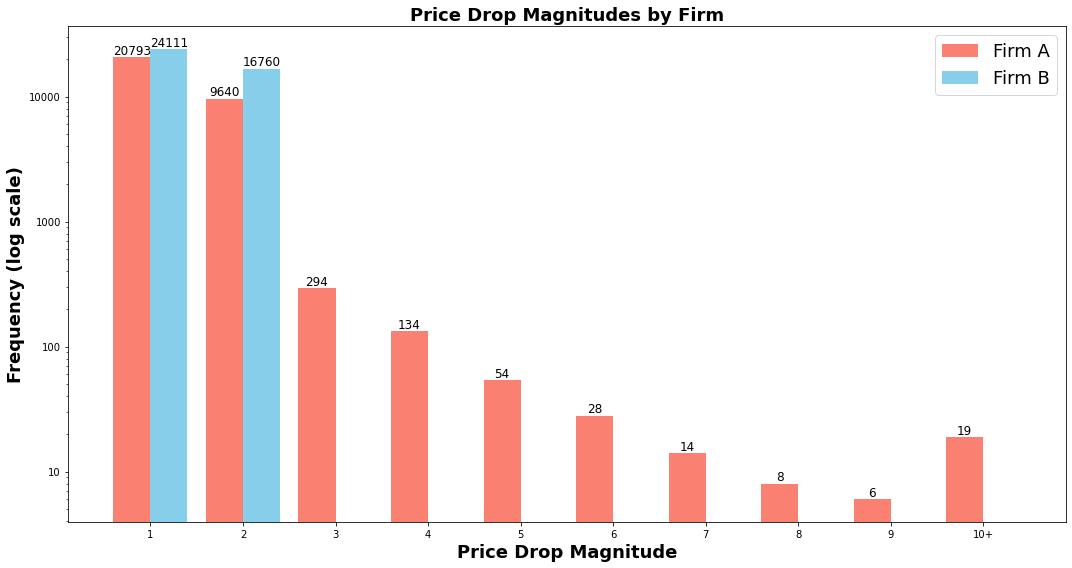

The highest price drop initiated by Firm A was: 21


In [19]:
import matplotlib.pyplot as plt
import numpy as np

drop_durations_A, drop_durations_B = [], []
drop_magnitudes_A, drop_magnitudes_B = [], []

last_price_A = price_history_A[0]
last_price_B = price_history_B[0]

drop_detected_A, drop_detected_B = False, False
drop_start_index_A, drop_start_index_B = 0, 0
drop_start_price_A, drop_start_price_B = last_price_A, last_price_B
lowest_price_A, lowest_price_B = last_price_A, last_price_B

for i in range(1, len(price_history_A)):
    current_price_A = price_history_A[i]
    current_price_B = price_history_B[i]

    if not drop_detected_A and current_price_A < last_price_A and current_price_A < current_price_B:
        drop_detected_A = True
        drop_start_price_A = last_price_A
        drop_start_index_A = i
        lowest_price_A = current_price_A

    if not drop_detected_B and current_price_B < last_price_B and current_price_B < current_price_A:
        drop_detected_B = True
        drop_start_price_B = last_price_B
        drop_start_index_B = i
        lowest_price_B = current_price_B

    if drop_detected_A:
        lowest_price_A = min(lowest_price_A, current_price_A)
        if current_price_A >= drop_start_price_A:
            duration = i - drop_start_index_A
            magnitude = drop_start_price_A - lowest_price_A
            drop_durations_A.append(duration)
            drop_magnitudes_A.append(magnitude)
            drop_detected_A = False

    if drop_detected_B:
        lowest_price_B = min(lowest_price_B, current_price_B)
        if current_price_B >= drop_start_price_B:
            duration = i - drop_start_index_B
            magnitude = drop_start_price_B - lowest_price_B
            drop_durations_B.append(duration)
            drop_magnitudes_B.append(magnitude)
            drop_detected_B = False

    last_price_A = current_price_A
    last_price_B = current_price_B


bins = np.append(np.arange(1, 11), [max(max(drop_magnitudes_A, default=0), max(drop_magnitudes_B, default=0)) + 1])

counts_A, _ = np.histogram(drop_magnitudes_A, bins=bins)
counts_B, _ = np.histogram(drop_magnitudes_B, bins=bins)
x = np.arange(len(bins) - 1)  # Positions for each bin

fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.4
ax.bar(x - bar_width / 2, counts_A, width=bar_width, color="salmon", label="Firm A")
ax.bar(x + bar_width / 2, counts_B, width=bar_width, color="skyblue", label="Firm B")

ax.set_title("Price Drop Magnitudes by Firm", fontsize=18, fontweight='bold')
ax.set_xlabel("Price Drop Magnitude", fontsize=18, fontweight='bold')
ax.set_ylabel("Frequency (log scale)", fontsize=18, fontweight='bold')
ax.set_yscale("log")
ax.set_xticks(x)
ax.set_xticklabels([str(int(m)) for m in bins[:-2]] + ["10+"], fontsize=10)
ax.legend(fontsize=18)

ax.yaxis.set_major_locator(mticker.LogLocator(base=10.0))
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

for i, (count_A, count_B) in enumerate(zip(counts_A, counts_B)):
    if count_A > 0:
        ax.text(i - bar_width / 2, count_A, str(count_A), ha="center", va="bottom", fontsize=12)
    if count_B > 0:
        ax.text(i + bar_width / 2, count_B, str(count_B), ha="center", va="bottom", fontsize=12)

plt.tight_layout()
plt.savefig("price_drop_magnitudes_bins_1.png", format="png", dpi=300)
plt.show()

print("The highest price drop initiated by Firm A was:", max(drop_magnitudes_A))